# Datalab

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from cleanlab.benchmarking.noise_generation import generate_noise_matrix_from_trace, generate_noisy_labels
from datasets import Dataset
from cleanlab.experimental.datalab.datalab import Datalab
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


SEED = 123
np.random.seed(SEED)

BINS = {
    "low": [0, 3.3],
    "mid": [3.3, 6.6],
    "high": [6.6, 10],
}

BINS_MAP = {
    "low": 0,
    "mid": 1,
    "high": 2,
}

In [2]:
X = np.random.rand(1000, 2) * 5
y = np.sum(X, axis=1)
# Map y to bins based on the BINS dict
y_bin = np.array([k for y_i in y for k, v in BINS.items()  if v[0] <= y_i < v[1]])
y_bin_idx = np.array([BINS_MAP[k] for k in y_bin])

# Split into train and test
X_train, X_test, y_train, y_test, y_train_idx, y_test_idx = train_test_split(X, y_bin, y_bin_idx, test_size=0.5, random_state=SEED)

py = np.bincount(y_train_idx) / float(len(y_train_idx))
m = len(BINS)

noise_matrix = generate_noise_matrix_from_trace(
    m,
    trace=0.9 * m,
    py=py,
    valid_noise_matrix=True,
    seed=SEED,
)

noisy_labels_idx = generate_noisy_labels(y_train_idx, noise_matrix)

# TODO: Add noise to test set when we support extra splits in DataLab

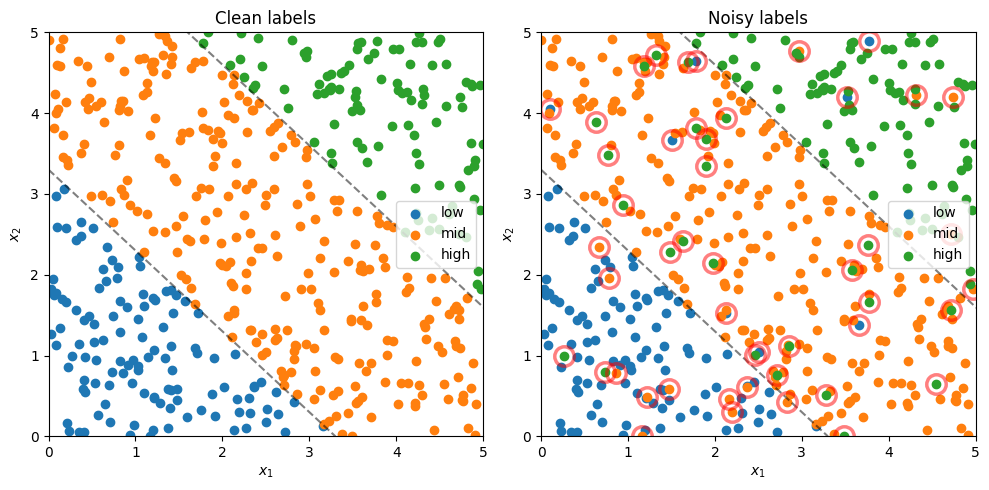

In [3]:
# Plot data with clean labels and noisy labels, use BINS_MAP for the legend
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, (X, y) in enumerate(zip([X_train, X_train], [y_train_idx, noisy_labels_idx])):
    for k, v in BINS_MAP.items():
        ax[i].scatter(X[y == v, 0], X[y == v, 1], label=k)
    ax[i].legend()
    ax[i].set_title(["Clean labels", "Noisy labels"][i])
    ax[i].set_xlabel(r"$x_1$")
    ax[i].set_ylabel(r"$x_2$")
    ax[i].set_xlim(0, 5)
    ax[i].set_ylim(0, 5)

# Plot true boundaries (x+y=3.3, x+y=6.6)
for i in range(2):
    ax[i].plot([0, 3.3], [3.3, 0], color="k", linestyle="--", alpha=0.5)
    ax[i].plot([0, 6.6], [6.6, 0], color="k", linestyle="--", alpha=0.5)

# Draw red circles around the points that are misclassified (i.e. the points that are in the wrong bin)
for i, (X, y) in enumerate(zip([X_train, X_train], [y_train_idx, noisy_labels_idx])):
    for k, v in BINS_MAP.items():
        ax[i].plot(
            X[(y == v) & (y != y_train_idx), 0],
            X[(y == v) & (y != y_train_idx), 1],
            "o",
            markerfacecolor="none",
            markeredgecolor="red",
            markersize=14,
            markeredgewidth=2.5,
            alpha=0.5,
        )


plt.tight_layout()

In [4]:
print(np.mean(noisy_labels_idx == y_train_idx))  # accuracy
noisy_labels = np.array([list(BINS_MAP.keys())[i] for i in noisy_labels_idx])

# Load data into DataLab
data = Dataset.from_dict({"X": X_train, "y": noisy_labels})

0.904


# Instantiate a Datalab object

Provide the data object and a name of the label column in the data object.

Most issue types currently rely on getting (out-of-sample) predictions from a trained model.
We'll use a simple logistic regression model for this example.

In [5]:
lab = Datalab(data, label_name="y")

model = LogisticRegression()
pred_probs = cross_val_predict(
    estimator=model, X=X_train, y=noisy_labels, cv=5, method="predict_proba"
)
lab.find_issues(pred_probs=pred_probs)


We can review some of the results:

In [6]:
# Datalab results
print("Results: ", lab.results)


Results:  0.902


In [7]:
lab.info["summary"]

{'overall_label_health_score': 0.902,
 'joint': array([[0.194, 0.006, 0.044],
        [0.006, 0.208, 0.014],
        [0.012, 0.016, 0.5  ]]),
 'classes_by_label_quality':   Class Name  Class Index  Label Issues  Inverse Label Issues  Label Noise  \
 0       high            0            25                     9     0.204918   
 1        low            1            10                    11     0.087719   
 2        mid            2            14                    29     0.053030   
 
    Inverse Label Noise  Label Quality Score  
 0             0.084906             0.795082  
 1             0.095652             0.912281  
 2             0.103943             0.946970  ,
 'overlapping_classes':   Class Name A Class Name B  Class Index A  Class Index B  \
 0         high          mid              0              2   
 1          low          mid              1              2   
 2         high          low              0              1   
 
    Num Overlapping Examples  Joint Probability  


In [8]:
# Per-example issues
print("Issues: ", lab.issues)


Issues:       is_label_issue  label_quality  given_label  predicted_label
0             False       0.664807            2                2
1             False       0.811638            2                2
2             False       0.502621            2                2
3             False       0.711050            0                0
4             False       0.587739            2                2
..              ...            ...          ...              ...
495           False       0.917158            1                1
496           False       0.968819            1                1
497           False       0.565863            2                2
498           False       0.670985            2                2
499           False       0.683090            0                0

[500 rows x 4 columns]


# Save the results

In [9]:
path = "test-lab"

In [10]:
lab.save(path)

Saved Datalab to folder: test-lab
The Dataset must be saved/loaded separately to access it after reloading this Datalab.


In [11]:
lab.info

{'num_examples': 500,
 'class_names': ['mid', 'high', 'low'],
 'num_classes': 3,
 'multi_label': False,
 'summary': {'overall_label_health_score': 0.902,
  'joint': array([[0.194, 0.006, 0.044],
         [0.006, 0.208, 0.014],
         [0.012, 0.016, 0.5  ]]),
  'classes_by_label_quality':   Class Name  Class Index  Label Issues  Inverse Label Issues  Label Noise  \
  0       high            0            25                     9     0.204918   
  1        low            1            10                    11     0.087719   
  2        mid            2            14                    29     0.053030   
  
     Inverse Label Noise  Label Quality Score  
  0             0.084906             0.795082  
  1             0.095652             0.912281  
  2             0.103943             0.946970  ,
  'overlapping_classes':   Class Name A Class Name B  Class Index A  Class Index B  \
  0         high          mid              0              2   
  1          low          mid              1  

# Load the Datalab


In [12]:

new_lab = Datalab.load(path)

In [14]:
new_lab.info

{'num_examples': 500,
 'class_names': ['mid', 'high', 'low'],
 'num_classes': 3,
 'multi_label': False,
 'summary': {'overall_label_health_score': 0.902,
  'joint': array([[0.194, 0.006, 0.044],
         [0.006, 0.208, 0.014],
         [0.012, 0.016, 0.5  ]]),
  'classes_by_label_quality':   Class Name  Class Index  Label Issues  Inverse Label Issues  Label Noise  \
  0       high            0            25                     9     0.204918   
  1        low            1            10                    11     0.087719   
  2        mid            2            14                    29     0.053030   
  
     Inverse Label Noise  Label Quality Score  
  0             0.084906             0.795082  
  1             0.095652             0.912281  
  2             0.103943             0.946970  ,
  'overlapping_classes':   Class Name A Class Name B  Class Index A  Class Index B  \
  0         high          mid              0              2   
  1          low          mid              1  

In [15]:
lab.__dict__

{'data': Dataset({
     features: ['X', 'y'],
     num_rows: 500
 }),
 'label_name': 'y',
 'issues':      is_label_issue  label_quality  given_label  predicted_label
 0             False       0.664807            2                2
 1             False       0.811638            2                2
 2             False       0.502621            2                2
 3             False       0.711050            0                0
 4             False       0.587739            2                2
 ..              ...            ...          ...              ...
 495           False       0.917158            1                1
 496           False       0.968819            1                1
 497           False       0.565863            2                2
 498           False       0.670985            2                2
 499           False       0.683090            0                0
 
 [500 rows x 4 columns],
 'results': 0.902,
 '_labels': array([2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 0

In [16]:
new_lab.__dict__

{'data': Dataset({
     features: ['X', 'y'],
     num_rows: 500
 }),
 'label_name': 'y',
 'issues':      Unnamed: 0  is_label_issue  label_quality  given_label  predicted_label
 0             0           False       0.664807            2                2
 1             1           False       0.811638            2                2
 2             2           False       0.502621            2                2
 3             3           False       0.711050            0                0
 4             4           False       0.587739            2                2
 ..          ...             ...            ...          ...              ...
 495         495           False       0.917158            1                1
 496         496           False       0.968819            1                1
 497         497           False       0.565863            2                2
 498         498           False       0.670985            2                2
 499         499           False       0.6